# 逆滤波

In [3]:
#coding:utf-8
%matplotlib inline
import numpy as np
import scipy
from scipy.special import comb
import matplotlib.pyplot as plt
import cv2
from scipy import stats
import scipy.ndimage.filters as nd_filters
import time
from numpy.linalg import cholesky
import scipy.signal as signal

In [2]:
gray = cv2.imread('../../datas/f4.jpg',0)
rgb = cv2.cvtColor(cv2.imread('../../datas/f4.jpg'),cv2.COLOR_BGR2RGB)
rows,cols,ch = rgb.shape

In [16]:
'''
运动模糊
'''
def blur(img, d):
    fil = np.zeros((d, d))
    fil[d//2, :] = 1/d
    return signal.convolve2d(img, fil, mode='same', boundary='wrap'),fil

In [17]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [18]:
blur_img,blur_kernel = blur(gray,31)
noise = noise_gaussian(rows,cols,a=0,b=0.1)
blur_noise_img = blur_img.astype(np.float32) + noise * 255
blur_noise_img[blur_noise_img < 0] = 0
blur_noise_img[blur_noise_img > 255] = 255
blur_noise_img = blur_noise_img.astype(np.uint8)

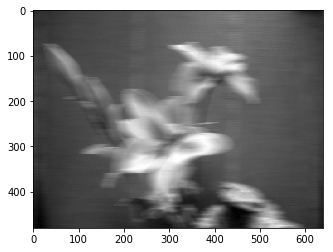

In [35]:
plt.imshow(blur_img,'gray')

In [48]:
def inverse_filter(blurred,kernel):
    eps = 1.0e-5
    rows,cols = blurred.shape[0],blurred.shape[1]
    bfft = np.fft.fft2(blurred)
    pfft = np.fft.fft2(kernel,(rows,cols))
    deblurred = np.fft.ifft2(bfft / (pfft + eps))
    return deblurred
#     bfft = np.fft.fft2(blurred)
#     pfft = np.fft.fft2(kernel,(rows,cols))
#     otf = psf2otf(pfft,pfft.shape)
#     otf[otf == 0] = eps
#     fedbl = bfft / otf
#     resim = np.fft.ifft2(fedbl)
#     return resim
    

In [49]:
deblurred = inverse_filter(blur_img,blur_kernel)

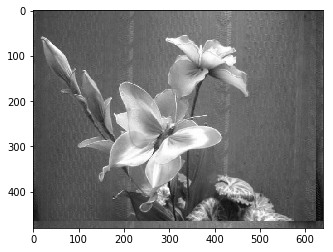

In [50]:
plt.imshow(np.abs(deblurred),'gray')

In [28]:
def udft2(image):
    """Unitary fft2"""
    norm = np.sqrt(image.size)
    return np.fft.fft2(image) / norm


def uidft2(image):
    """Unitary ifft2"""
    norm = np.sqrt(image.size)
    return np.fft.ifft2(image) * norm


def psf2otf(psf, shape):
    """
    Convert point-spread function to optical transfer function.
    Compute the Fast Fourier Transform (FFT) of the point-spread
    function (PSF) array and creates the optical transfer function (OTF)
    array that is not influenced by the PSF off-centering.
    By default, the OTF array is the same size as the PSF array.
    To ensure that the OTF is not altered due to PSF off-centering, PSF2OTF
    post-pads the PSF array (down or to the right) with zeros to match
    dimensions specified in OUTSIZE, then circularly shifts the values of
    the PSF array up (or to the left) until the central pixel reaches (1,1)
    position.
    Parameters
    ----------
    psf : `numpy.ndarray`
        PSF array
    shape : int
        Output shape of the OTF array
    Returns
    -------
    otf : `numpy.ndarray`
        OTF array
    Notes
    -----
    Adapted from MATLAB psf2otf function
    """
    if np.all(psf == 0):
        return np.zeros_like(psf)

    inshape = psf.shape
    # Pad the PSF to outsize
    psf = zero_pad(psf, shape, position='corner')

    # Circularly shift OTF so that the 'center' of the PSF is
    # [0,0] element of the array
    for axis, axis_size in enumerate(inshape):
        psf = np.roll(psf, -int(axis_size / 2), axis=axis)

    # Compute the OTF
    otf = np.fft.fft2(psf)

    # Estimate the rough number of operations involved in the FFT
    # and discard the PSF imaginary part if within roundoff error
    # roundoff error  = machine epsilon = sys.float_info.epsilon
    # or np.finfo().eps
    n_ops = np.sum(psf.size * np.log2(psf.shape))
    otf = np.real_if_close(otf, tol=n_ops)

    return otf

In [31]:
def zero_pad(image, shape, position='corner'):
    """
    Extends image to a certain size with zeros
    Parameters
    ----------
    image: real 2d `numpy.ndarray`
        Input image
    shape: tuple of int
        Desired output shape of the image
    position : str, optional
        The position of the input image in the output one:
            * 'corner'
                top-left corner (default)
            * 'center'
                centered
    Returns
    -------
    padded_img: real `numpy.ndarray`
        The zero-padded image
    """
    shape = np.asarray(shape, dtype=int)
    imshape = np.asarray(image.shape, dtype=int)

    if np.alltrue(imshape == shape):
        return image

    if np.any(shape <= 0):
        raise ValueError("ZERO_PAD: null or negative shape given")

    dshape = shape - imshape
    if np.any(dshape < 0):
        raise ValueError("ZERO_PAD: target size smaller than source one")

    pad_img = np.zeros(shape, dtype=image.dtype)

    idx, idy = np.indices(imshape)

    if position == 'center':
        if np.any(dshape % 2 != 0):
            raise ValueError("ZERO_PAD: source and target shapes "
                             "have different parity.")
        offx, offy = dshape // 2
    else:
        offx, offy = (0, 0)

    pad_img[idx + offx, idy + offy] = image

    return pad_img